In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from collections import Counter
import random, warnings
warnings.filterwarnings("ignore")

In [5]:
def preprocess_data(df, is_training=True, encoders=None, feature_cols=None):
    df = df.copy()

    # Fill missing values
    for col in ['Ever_Married', 'Work_Experience', 'Var_1', 'Family_Size', 'Graduated', 'Profession']:
        if col in df:
            df[col] = df[col].ffill()

    # Encode Gender
    if "Gender" in df:
        df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})

    # Encode Yes/No columns
    for col in ["Ever_Married", "Graduated"]:
        if col in df:
            df[col] = df[col].map({"Yes": 1, "No": 0})

    # Label encode selected categorical columns
    if is_training:
        encoders = {}
        for col in ["Profession", "Spending_Score", "Var_1"]:
            if col in df:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
                encoders[col] = le
    else:
        for col in ["Profession", "Spending_Score", "Var_1"]:
            if col in encoders:
                df[col] = df[col].astype(str)
                df[col] = df[col].apply(lambda x: x if x in encoders[col].classes_ else encoders[col].classes_[0])
                df[col] = encoders[col].transform(df[col])

    # Drop ID if present
    if "ID" in df.columns:
        df.drop("ID", axis=1, inplace=True)

    # Split
    if "Segmentation" in df.columns:
        X = df.drop("Segmentation", axis=1)
        y = df["Segmentation"]
    else:
        X, y = df, None

    # One-hot encode categorical columns
    X = pd.get_dummies(X, drop_first=True)

    # Ensure same columns for test data
    if not is_training:
        X = X.reindex(columns=feature_cols, fill_value=0)

    return X, y, encoders

In [6]:
def advanced_random_forest(X_train, y_train, X_test, n_trees=80, max_depth_range=(6, 15),
                           feature_ratio=0.5, sample_ratio=0.8, min_samples_split=6,
                           min_samples_leaf=4, criterion="entropy"):
    np.random.seed(42)
    random.seed(42)
    n_samples, n_features = X_train.shape
    n_features_sub = int(feature_ratio * n_features)
    sample_size = int(sample_ratio * n_samples)

    trees, feature_subsets = [], []

    for i in range(n_trees):
        indices = []
        for cls in np.unique(y_train):
            cls_idx = np.where(np.array(y_train) == cls)[0]
            cls_sample = np.random.choice(cls_idx, int(sample_size / len(np.unique(y_train))), replace=True)
            indices.extend(cls_sample)
        np.random.shuffle(indices)

        feature_idx = np.random.choice(n_features, n_features_sub, replace=False)
        feature_subsets.append(feature_idx)

        X_boot = X_train[indices][:, feature_idx]
        y_boot = np.array(y_train)[indices]

        depth = np.random.randint(max_depth_range[0], max_depth_range[1] + 1)
        tree = DecisionTreeClassifier(
            criterion=criterion,
            max_depth=depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=i
        )
        tree.fit(X_boot, y_boot)
        trees.append(tree)

    # --- Predict via majority vote ---
    preds = []
    for i, tree in enumerate(trees):
        X_test_sub = X_test[:, feature_subsets[i]]
        preds.append(tree.predict(X_test_sub))

    preds = np.array(preds).T
    final_preds = [Counter(row).most_common(1)[0][0] for row in preds]
    return np.array(final_preds)

Hyperparameter tuning in progress...

depth=(6, 12), features=0.4, sample=0.7 → acc=30.48%
depth=(6, 12), features=0.4, sample=0.8 → acc=30.88%
depth=(6, 12), features=0.5, sample=0.7 → acc=31.77%
depth=(6, 12), features=0.5, sample=0.8 → acc=31.29%
depth=(6, 12), features=0.6, sample=0.7 → acc=31.63%
depth=(6, 12), features=0.6, sample=0.8 → acc=32.45%
depth=(8, 18), features=0.4, sample=0.7 → acc=29.86%
depth=(8, 18), features=0.4, sample=0.8 → acc=30.61%
depth=(8, 18), features=0.5, sample=0.7 → acc=31.77%
depth=(8, 18), features=0.5, sample=0.8 → acc=32.11%
depth=(8, 18), features=0.6, sample=0.7 → acc=31.22%
depth=(8, 18), features=0.6, sample=0.8 → acc=32.52%
depth=(10, 22), features=0.4, sample=0.7 → acc=29.59%
depth=(10, 22), features=0.4, sample=0.8 → acc=31.22%
depth=(10, 22), features=0.5, sample=0.7 → acc=31.90%
depth=(10, 22), features=0.5, sample=0.8 → acc=31.50%
depth=(10, 22), features=0.6, sample=0.7 → acc=31.29%
depth=(10, 22), features=0.6, sample=0.8 → acc=33.20%

B

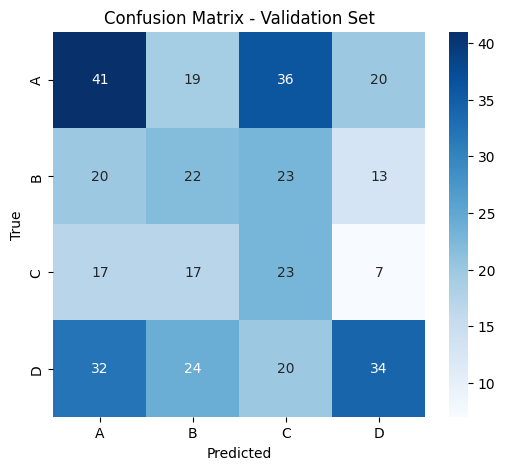


Loading test dataset...
🔹 Generating predictions for test data...

All Test Predictions:
    Predicted
0           D
1           A
2           A
3           C
4           B
..        ...
784         D
785         C
786         D
787         D
788         B

[789 rows x 1 columns]


In [7]:
def main():
    # --- Load training data ---
    df = pd.read_csv("Customer_train.csv")
    X, y, encoders = preprocess_data(df, is_training=True)
    feature_cols = X.columns
    X_np, y_np = X.values, y.values

    # --- Split for validation ---
    X_train, X_val, y_train, y_val = train_test_split(X_np, y_np, test_size=0.2,
                                                      stratify=y_np, random_state=42)

    # --- Hyperparameter tuning ---
    depth_ranges = [(6, 12), (8, 18), (10, 22)]
    feature_ratios = [0.4, 0.5, 0.6]
    sample_ratios = [0.7, 0.8]

    best_acc, best_cfg = 0, None
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    print("Hyperparameter tuning in progress...\n")

    for d in depth_ranges:
        for f in feature_ratios:
            for s in sample_ratios:
                accs = []
                for train_idx, val_idx in kf.split(X_train, y_train):
                    Xtr, Xv = X_train[train_idx], X_train[val_idx]
                    ytr, yv = y_train[train_idx], y_train[val_idx]
                    y_pred = advanced_random_forest(Xtr, ytr, Xv,
                                                    n_trees=60,
                                                    max_depth_range=d,
                                                    feature_ratio=f,
                                                    sample_ratio=s)
                    accs.append(accuracy_score(yv, y_pred))
                mean_acc = np.mean(accs)
                print(f"depth={d}, features={f}, sample={s} → acc={mean_acc*100:.2f}%")
                if mean_acc > best_acc:
                    best_acc, best_cfg = mean_acc, (d, f, s)

    print(f"\nBest mean accuracy: {best_acc*100:.2f}%")
    print(f"Best params → depth={best_cfg[0]}, feature_ratio={best_cfg[1]}, sample_ratio={best_cfg[2]}")

    # --- Train final model on training data ---
    best_depth, best_feat, best_samp = best_cfg
    y_val_pred = advanced_random_forest(X_train, y_train, X_val,
                                        n_trees=150,
                                        max_depth_range=best_depth,
                                        feature_ratio=best_feat,
                                        sample_ratio=best_samp)

    # --- Evaluate on validation set ---
    val_acc = accuracy_score(y_val, y_val_pred)
    print(f"\nFinal Random Forest Validation Accuracy: {val_acc*100:.2f}%")
    print("\nClassification Report on Validation Set:")
    print(classification_report(y_val, y_val_pred))

    # Confusion matrix (Validation)
    cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(y_val))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
    plt.title("Confusion Matrix - Validation Set")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # --- Load and Predict on Test Dataset ---
    print("\nLoading test dataset...")
    df_test = pd.read_csv("Customer_test.csv")
    X_test, y_test, _ = preprocess_data(df_test, is_training=False, encoders=encoders, feature_cols=feature_cols)
    X_test_np = X_test.values

    print("🔹 Generating predictions for test data...")
    y_test_pred = advanced_random_forest(X_train, y_train, X_test_np,
                                         n_trees=150,
                                         max_depth_range=best_depth,
                                         feature_ratio=best_feat,
                                         sample_ratio=best_samp)

    # --- Print ALL predictions ---
    print("\nAll Test Predictions:")
    predictions_df = pd.DataFrame({"Predicted": y_test_pred})
    print(predictions_df)

    # Optional: Save predictions to CSV
    predictions_df.to_csv("random_predictions.csv", index=False)
    # print("\nPredictions saved to random_predictions.csv")

    # --- If ground truth exists, compute full metrics ---
    if y_test is not None:
        test_acc = accuracy_score(y_test, y_test_pred)
        prec = precision_score(y_test, y_test_pred, average='macro')
        rec = recall_score(y_test, y_test_pred, average='macro')
        f1 = f1_score(y_test, y_test_pred, average='macro')

        print(f"\nTest Accuracy: {test_acc*100:.2f}%")
        print(f"Precision (macro): {prec*100:.2f}%")
        print(f"Recall (macro): {rec*100:.2f}%")
        print(f"F1-score (macro): {f1*100:.2f}%")

        print("\nClassification Report on Test Data:")
        print(classification_report(y_test, y_test_pred))

        # Confusion matrix (Test)
        cm_test = confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test))
        plt.figure(figsize=(6,5))
        sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title("Confusion Matrix - Test Set")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

# Run main in notebook
main()